In [4]:
!pip3 install hmmlearn -q

In [5]:
# Block 1: Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

np.random.seed(42)

# Define states and observations characteristics
states = ["Sunny", "Cloudy", "Rainy"]
n_states = len(states)

# Observations: [Temperature (°C), Humidity (%)] - simplified means/covs
means = np.array([[25.0, 40.0],  # Sunny
                  [18.0, 65.0],  # Cloudy
                  [12.0, 85.0]]) # Rainy

covars = np.array([[[5.0, 0.0], [0.0, 10.0]],   # Sunny
                   [[4.0, 0.0], [0.0, 8.0]],    # Cloudy
                   [[3.0, 0.0], [0.0, 5.0]]])   # Rainy (assuming independence for simplicity)

# Transition probabilities (example)
transmat = np.array([[0.7, 0.2, 0.1],
                     [0.3, 0.5, 0.2],
                     [0.2, 0.4, 0.4]])

# Start probabilities (example)
startprob = np.array([0.6, 0.3, 0.1])

In [6]:
# Block 2: Generate Synthetic Data using a Gaussian HMM definition
model_gen = hmm.GaussianHMM(n_components=n_states, covariance_type="full", random_state=42)
model_gen.startprob_ = startprob
model_gen.transmat_ = transmat
model_gen.means_ = means
model_gen.covars_ = covars

# Generate a sequence of observations and true hidden states
X_obs, Z_true = model_gen.sample(100)

print("Generated Observations (first 5):")
print(X_obs[:5])
print("\nTrue Hidden States (first 5):")
print(Z_true[:5])

Generated Observations (first 5):
[[25.71308696 36.48392634]
 [26.71603622 44.99390941]
 [23.82568461 38.16310205]
 [20.72177531 40.76515189]
 [21.59250968 42.58182604]]

True Hidden States (first 5):
[0 0 0 0 0]


In [7]:
# Block 3: Continuous HMM (GaussianHMM) Training and Prediction
model_cont = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=100, random_state=10)
model_cont.fit(X_obs)

Z_pred_cont = model_cont.predict(X_obs)

print("\n--- Continuous HMM (GaussianHMM) ---")
print("Learned Start Probabilities:")
print(model_cont.startprob_)
print("\nLearned Transition Matrix:")
print(model_cont.transmat_)
print("\nLearned Means:")
print(model_cont.means_)

# Evaluate (compare predicted vs true states - requires careful state mapping)
# Simple accuracy check (assuming states align, which might not be true)
accuracy_cont = np.mean(Z_pred_cont == Z_true) # This is a rough estimate
print(f"\nApproximate Continuous HMM Accuracy (vs generated): {accuracy_cont:.4f}")


--- Continuous HMM (GaussianHMM) ---
Learned Start Probabilities:
[3.58499337e-37 1.00000000e+00 3.65177068e-92]

Learned Transition Matrix:
[[1.85515305e-06 9.99998144e-01 1.09859026e-09]
 [3.91197910e-02 8.32255321e-01 1.28624888e-01]
 [7.89334108e-02 5.58394049e-02 8.65227184e-01]]

Learned Means:
[[18.97608545 61.11575777]
 [25.40865676 39.07168454]
 [14.97591852 75.77893627]]

Approximate Continuous HMM Accuracy (vs generated): 0.2600


In [8]:
# Block 4: Discrete HMM (MultinomialHMM) - Discretize Data
from sklearn.preprocessing import KBinsDiscretizer

# Discretize Temperature and Humidity into bins (e.g., 3 bins each)
n_bins = 3
est_temp = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform', subsample=None)
est_hum = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform', subsample=None)

temp_discrete = est_temp.fit_transform(X_obs[:, 0].reshape(-1, 1))
hum_discrete = est_hum.fit_transform(X_obs[:, 1].reshape(-1, 1))

# Combine discrete features into a single observation symbol per time step
# Example: (TempBin * n_bins_humidity) + HumidityBin
X_discrete = (temp_discrete * n_bins + hum_discrete).astype(int).flatten()
n_features_discrete = n_bins * n_bins # Total number of unique discrete observation symbols

print("\nDiscretized Observations (first 10):")
print(X_discrete[:10])


Discretized Observations (first 10):
[6 6 6 3 3 3 6 6 6 6]


In [9]:
# Block 5: Discrete HMM (MultinomialHMM) Training and Prediction
model_disc = hmm.MultinomialHMM(n_components=n_states, n_iter=100, random_state=20)
# Need to reshape X_discrete for fitting: (n_samples, 1)
model_disc.fit(X_discrete.reshape(-1, 1))

Z_pred_disc = model_disc.predict(X_discrete.reshape(-1, 1))

print("\n--- Discrete HMM (MultinomialHMM) ---")
print("Learned Start Probabilities:")
print(model_disc.startprob_)
print("\nLearned Transition Matrix:")
print(model_disc.transmat_)
print("\nLearned Emission Probabilities (Shape: n_states x n_features_discrete):")
print(model_disc.emissionprob_.shape)

# Evaluate (compare predicted vs true states - requires careful state mapping)
accuracy_disc = np.mean(Z_pred_disc == Z_true) # Rough estimate
print(f"\nApproximate Discrete HMM Accuracy (vs generated): {accuracy_disc:.4f}")

print(f"\nComparison (Approximate Accuracy):")
print(f"Continuous HMM: {accuracy_cont:.4f}")
print(f"Discrete HMM:   {accuracy_disc:.4f}")

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



--- Discrete HMM (MultinomialHMM) ---
Learned Start Probabilities:
[1.52814761e-01 8.47150513e-01 3.47255286e-05]

Learned Transition Matrix:
[[0.08968906 0.03335343 0.87695751]
 [0.00181968 0.01567597 0.98250435]
 [0.19196243 0.53555173 0.27248585]]

Learned Emission Probabilities (Shape: n_states x n_features_discrete):
(3, 1)

Approximate Discrete HMM Accuracy (vs generated): 0.2900

Comparison (Approximate Accuracy):
Continuous HMM: 0.2600
Discrete HMM:   0.2900


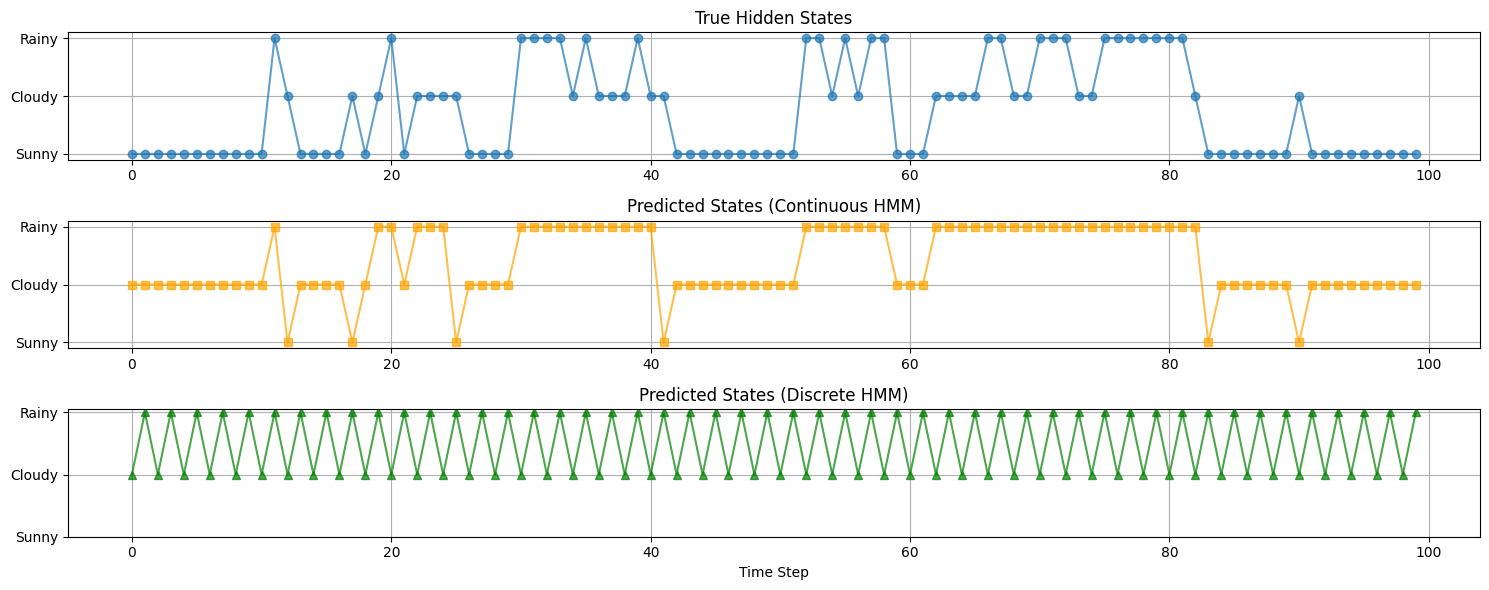

In [10]:
# Block 6: Visualize Results (Example: True vs Predicted States)
plt.figure(figsize=(15, 6))

plt.subplot(3, 1, 1)
plt.plot(Z_true, '-o', label='True States', alpha=0.7)
plt.title('True Hidden States')
plt.yticks(range(n_states), states)
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(Z_pred_cont, '-s', label='Predicted (Continuous)', alpha=0.7, color='orange')
plt.title('Predicted States (Continuous HMM)')
plt.yticks(range(n_states), states)
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(Z_pred_disc, '-^', label='Predicted (Discrete)', alpha=0.7, color='green')
plt.title('Predicted States (Discrete HMM)')
plt.yticks(range(n_states), states)
plt.xlabel('Time Step')
plt.grid(True)

plt.tight_layout()
plt.show()